In [0]:
import torch
from torch import nn,functional
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText
import os
import matplotlib.pyplot as plt
%matplotlib inline
torch.cuda.set_device(0)

# Dataloaders

In [2]:
TEXT = data.Field()
LABEL = data.Field(sequential=False,dtype=torch.long)
train, val, test = datasets.SST.splits(
    TEXT, LABEL, fine_grained=True, train_subtrees=False)

# print information about the data
print('train.fields', train.fields)
print('len(train)', len(train))
print('vars(train[0])', vars(train[0]))

# build the vocabulary
# you can use other pretrained vectors, refer to https://github.com/pytorch/text/blob/master/torchtext/vocab.py
TEXT.build_vocab(train, vectors=Vectors(name='vector.txt', cache='drive/My Drive/Colab Notebooks/data'))
LABEL.build_vocab(train)
# We can also see the vocabulary directly using either the stoi (string to int) or itos (int to string) method.
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)
print(TEXT.vocab.freqs.most_common(20))

# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())

# make iterator for splits
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_size=64)

# print batch information
batch = next(iter(train_iter)) # for batch in train_iter
print(batch.text) # input sequence
print(batch.label) # groud truth

train.fields {'text': <torchtext.data.field.Field object at 0x7fa89a0f8978>, 'label': <torchtext.data.field.Field object at 0x7fa89a0f8940>}
len(train) 8544
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}
['<unk>', '<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to', "'s"]
defaultdict(<function _default_unk_index at 0x7fa89a199400>, {'<unk>': 0, 'positive': 1, 'negative': 2, 'neutral': 3, 'very positive': 4, 'very negative': 5})
[('.', 8024), (',', 7131), ('the', 6037), ('and', 4431), ('a', 4403), ('of', 4386), ('to', 2995), ("'s", 2544), ('is', 2536), ('that', 1915), ('in', 1789), ('it', 1775), ('The', 1265), ('as', 1200), ('film', 1152), ('but', 1076), ('with', 1071), ('for', 963), ('movie', 959), ('its

In [3]:
# Copy the pre-trained word embeddings we loaded earlier into the embedding layer of our model.
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([18280, 300])


## Network

In [0]:
class SN(nn.Module):
    def __init__(self,embed_size, num_hiddens, num_layers,
                 bidirectional, labels, **kwargs):
        super(SN, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.embedding.weight.requires_grad = False
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
                               num_layers=num_layers, bidirectional=self.bidirectional,
                               dropout=0.4)
        if self.bidirectional:
            self.fc = nn.Linear(num_hiddens * 4, labels)
        else:
            self.fc = nn.Linear(num_hiddens, labels)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.4)


    def forward(self, inputs):
        embeddings = self.dropout(self.embedding(inputs))
        states, hidden = self.encoder(embeddings)
        encoding = torch.cat([states[0], states[-1]], dim=1)
        
        out = self.dropout(self.fc(encoding))
        out = self.softmax(out)
        return out

In [5]:
embed_size = 300
num_hiddens = 100
num_layers = 2
bidirectional = True
labels = 5
batch_size = 256

model = SN(embed_size=embed_size,num_hiddens=num_hiddens, num_layers=num_layers,bidirectional=bidirectional,labels=labels)
device = torch.device('cuda:0')
model.to(device)
print(model)

SN(
  (embedding): Embedding(18280, 300)
  (encoder): LSTM(300, 100, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=400, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum =0.9, weight_decay=1e-5)


In [7]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350],
        ...,
        [ 0.0495, -0.2737, -0.2819,  ..., -0.2686,  0.5445,  0.1999],
        [ 0.8430, -0.0559, -0.0837,  ...,  0.9208, -0.2708, -0.4322],
        [ 0.4218,  0.2891,  0.6224,  ..., -0.0994, -0.3216, -0.2066]],
       device='cuda:0')

## Model Training

In [8]:
train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), batch_size=batch_size,shuffle=True)
epochs = 1000
training_loss =[]
validation_loss =[]
validation_acc =[]

for epoch in range(epochs):
    model.zero_grad()
    model.train()
    train_loss = 0
    accuracy = 0
    for batch in train_iter:
        text = batch.text.to(device)
        label = batch.label-1
        label = label.to(device)
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        accuracy += torch.sum(torch.argmax(output,1)==label).item()/256

    with torch.no_grad():
        model.eval()
    valid_loss = 0
    valid_acc = 0
    for validation_batch in val_iter:
        validation_text = validation_batch.text.to(device)
        validation_label = validation_batch.label-1
        validation_label = validation_label.to(device)
        validation_output = model.forward(validation_text)

        valid_loss += criterion(validation_output,validation_label).item()
        valid_acc += torch.sum(torch.argmax(validation_output,1)==validation_label).cpu().item()/256

    training_loss.append(train_loss/len(train_iter))
    validation_loss.append(valid_loss/len(val_iter))
    validation_acc.append(valid_acc/len(val_iter))

    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Train Loss: {:.3f}.. ".format(train_loss/len(train_iter)),
              "Train_Acc: {:.3f}.. ".format(accuracy/len(train_iter)),
              "Val Loss: {:.3f}.. ".format(valid_loss/len(val_iter)),
              "Val_Acc: {:.3f}".format(valid_acc/len(val_iter)))

Epoch: 1/1000..  Train Loss: 1.600..  Train_Acc: 0.243..  Val Loss: 1.591..  Val_Acc: 0.218
Epoch: 2/1000..  Train Loss: 1.587..  Train_Acc: 0.260..  Val Loss: 1.585..  Val_Acc: 0.218
Epoch: 3/1000..  Train Loss: 1.588..  Train_Acc: 0.258..  Val Loss: 1.584..  Val_Acc: 0.218
Epoch: 4/1000..  Train Loss: 1.590..  Train_Acc: 0.247..  Val Loss: 1.584..  Val_Acc: 0.218
Epoch: 5/1000..  Train Loss: 1.586..  Train_Acc: 0.259..  Val Loss: 1.582..  Val_Acc: 0.242
Epoch: 6/1000..  Train Loss: 1.587..  Train_Acc: 0.251..  Val Loss: 1.581..  Val_Acc: 0.261
Epoch: 7/1000..  Train Loss: 1.586..  Train_Acc: 0.259..  Val Loss: 1.581..  Val_Acc: 0.225
Epoch: 8/1000..  Train Loss: 1.584..  Train_Acc: 0.257..  Val Loss: 1.579..  Val_Acc: 0.258
Epoch: 9/1000..  Train Loss: 1.584..  Train_Acc: 0.265..  Val Loss: 1.579..  Val_Acc: 0.229
Epoch: 10/1000..  Train Loss: 1.585..  Train_Acc: 0.261..  Val Loss: 1.576..  Val_Acc: 0.278
Epoch: 11/1000..  Train Loss: 1.579..  Train_Acc: 0.277..  Val Loss: 1.573..  V

### Testing

In [9]:
with torch.no_grad():
    model.eval()
test_loss = 0
test_accuracy = 0
for batch in test_iter:
    text= batch.text.to(device)
    label = batch.label -1
    label = label.to(device)

    output = model.forward(text)
    test_loss += criterion(output,label).item()

    test_accuracy += torch.sum(torch.argmax(output,1)==label).cpu().item()/256

print("Test Loss: {:.3f}.. ".format(test_loss/len(test_iter)),
        "Test Accuracy: {:.3f}".format(test_accuracy/len(test_iter)))

Test Loss: 1.495..  Test Accuracy: 0.387


### Plot

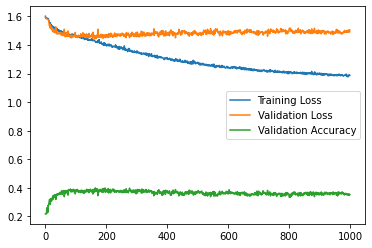

In [10]:
plt.plot(training_loss, label ='Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.plot(validation_acc, label = 'Validation Accuracy')
plt.legend(frameon = True)